In [1]:
import os
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (
    Input, Dense, Dropout, LayerNormalization, MultiHeadAttention, GlobalAveragePooling1D,
    Conv1D, BatchNormalization, Activation, MaxPooling1D, Concatenate, Add, Multiply
)
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

SEED = 42
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)

print(tf.__version__)

2.20.0


## 데이터 로딩 유틸리티 (transformer.ipynb 참고)

In [2]:
def load_file(filepath):
    dataframe = pd.read_csv(filepath, header=None, delim_whitespace=True)
    return dataframe.values

# load a list of files and return as a 3d numpy array
def load_group(filenames, prefix=''):
    loaded = list()
    for name in filenames:
        data = load_file(prefix + name)
        loaded.append(data)
    # stack group so that features are the 3rd dimension
    loaded = np.dstack(loaded)
    return loaded

# load a dataset group, such as train or test
def load_dataset_group(group, prefix=''):
    filepath = prefix + group + '/Inertial Signals/'
    # load all 9 files as a single array
    filenames = list()
    # total acceleration
    filenames += ['total_acc_x_'+group+'.txt', 'total_acc_y_'+group+'.txt', 'total_acc_z_'+group+'.txt']
    # body acceleration
    filenames += ['body_acc_x_'+group+'.txt', 'body_acc_y_'+group+'.txt', 'body_acc_z_'+group+'.txt']
    # body gyroscope
    filenames += ['body_gyro_x_'+group+'.txt', 'body_gyro_y_'+group+'.txt', 'body_gyro_z_'+group+'.txt']
    # load input data
    X = load_group(filenames, filepath)
    # load class output
    y = load_file(prefix + group + '/y_'+group+'.txt')
    return X, y

# load the dataset, returns train and test X and y elements
def load_dataset(prefix=''):
    # load all train
    trainX, trainy = load_dataset_group('train', prefix + './data/UCI HAR Dataset/UCI HAR Dataset/')
    # load all test
    testX, testy = load_dataset_group('test', prefix + './data/UCI HAR Dataset/UCI HAR Dataset/')

    # zero-offset class values
    trainy = trainy - 1
    testy = testy - 1
    # one hot encode y
    trainy_one_hot = to_categorical(trainy)
    testy_one_hot = to_categorical(testy)
    print('Shapes ->', trainX.shape, trainy.shape, trainy_one_hot.shape, testX.shape, testy.shape, testy_one_hot.shape)
    return trainX, trainy, trainy_one_hot, testX, testy, testy_one_hot

trainX, trainy, trainy_one_hot, testX, testy, testy_one_hot = load_dataset()

# Train/Val split (stratified)
X_train, X_val, y_train_one_hot, y_val_one_hot, y_train, y_val = train_test_split(
    trainX, trainy_one_hot, trainy, test_size=0.2, random_state=SEED, stratify=trainy
)
X_train.shape, X_val.shape, y_train_one_hot.shape, y_val_one_hot.shape, y_train.shape, y_val.shape


C:\Users\luili\AppData\Local\Temp\ipykernel_9840\193669400.py:2: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  dataframe = pd.read_csv(filepath, header=None, delim_whitespace=True)
C:\Users\luili\AppData\Local\Temp\ipykernel_9840\193669400.py:2: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  dataframe = pd.read_csv(filepath, header=None, delim_whitespace=True)
C:\Users\luili\AppData\Local\Temp\ipykernel_9840\193669400.py:2: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  dataframe = pd.read_csv(filepath, header=None, delim_whitespace=True)
C:\Users\luili\AppData\Local\Temp\ipykernel_9840\193669400.py:2: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in 

Shapes -> (7352, 128, 9) (7352, 1) (7352, 6) (2947, 128, 9) (2947, 1) (2947, 6)


((5881, 128, 9), (1471, 128, 9), (5881, 6), (1471, 6), (5881, 1), (1471, 1))

## 표준화 (train 통계로 train/val/test 모두 변환)

In [3]:
# per-channel standardization using training set statistics
channel_mean = X_train.mean(axis=(0,1), keepdims=True)
channel_std = X_train.std(axis=(0,1), keepdims=True) + 1e-8

X_train = (X_train - channel_mean) / channel_std
X_val   = (X_val   - channel_mean) / channel_std
testX   = (testX   - channel_mean) / channel_std

n_timesteps, n_features, n_outputs = X_train.shape[1], X_train.shape[2], y_train_one_hot.shape[1]
n_timesteps, n_features, n_outputs


(128, 9, 6)

## 모델 구성 요소: InceptionTime 블록 + SE 채널 어텐션 + Transformer Encoder

In [4]:
# Squeeze-and-Excitation block
def se_block(inputs, reduction=16):
    channels = inputs.shape[-1]
    x = GlobalAveragePooling1D()(inputs)
    x = Dense(max(channels // reduction, 8), activation='relu')(x)
    x = Dense(channels, activation='sigmoid')(x)
    x = layers.Reshape((1, channels))(x)
    return Multiply()([inputs, x])

# InceptionTime module (with bottleneck + residual)
def inception_module(inputs, nb_filters=64, kernel_sizes=(9,19,39), bottleneck_size=32):
    x = inputs
    if inputs.shape[-1] > 1 and bottleneck_size is not None:
        x = Conv1D(bottleneck_size, kernel_size=1, padding='same', use_bias=False)(x)
        x = BatchNormalization()(x)
        x = Activation('relu')(x)

    branches = []
    for k in kernel_sizes:
        b = Conv1D(nb_filters, kernel_size=k, padding='same', use_bias=False)(x)
        b = BatchNormalization()(b)
        b = Activation('relu')(b)
        branches.append(b)

    # MaxPool branch + 1x1 conv
    mp = MaxPooling1D(pool_size=3, strides=1, padding='same')(inputs)
    mp = Conv1D(nb_filters, kernel_size=1, padding='same', use_bias=False)(mp)
    mp = BatchNormalization()(mp)
    mp = Activation('relu')(mp)
    branches.append(mp)

    x = Concatenate(axis=-1)(branches)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    # Residual connection
    res = inputs
    if res.shape[-1] != x.shape[-1]:
        res = Conv1D(x.shape[-1], kernel_size=1, padding='same')(res)
    x = Add()([x, res])
    x = Activation('relu')(x)
    return x

# Positional Encoding layer
class PositionalEncoding(layers.Layer):
    def __init__(self, d_model, max_len=5000):
        super().__init__()
        position = np.arange(max_len)[:, np.newaxis]
        div_term = np.exp(np.arange(0, d_model, 2) * -(np.log(10000.0) / d_model))
        pos_encoding = np.zeros((max_len, d_model))
        pos_encoding[:, 0::2] = np.sin(position * div_term)
        pos_encoding[:, 1::2] = np.cos(position * div_term)
        pos_encoding = pos_encoding[np.newaxis, :, :]
        self.pos_encoding = tf.constant(pos_encoding, dtype=tf.float32)

    def call(self, x):
        seq_len = tf.shape(x)[1]
        return x + self.pos_encoding[:, :seq_len, :]

def transformer_encoder_block(inputs, head_size, num_heads, ff_dim, dropout=0.1):
    x = LayerNormalization(epsilon=1e-6)(inputs)
    x = MultiHeadAttention(key_dim=head_size, num_heads=num_heads, dropout=dropout)(x, x)
    x = Dropout(dropout)(x)
    res = Add()([x, inputs])

    x = LayerNormalization(epsilon=1e-6)(res)
    x = Dense(ff_dim, activation='relu')(x)
    x = Dropout(dropout)(x)
    x = Dense(inputs.shape[-1])(x)
    x = Dropout(dropout)(x)
    return Add()([x, res])

def build_inception_transformer_model(input_shape, n_classes,
                                      nb_filters=64, inc_blocks=3,
                                      head_size=64, num_heads=4, ff_dim=256,
                                      trans_blocks=2, dropout=0.1, mlp_units=(128, 64), mlp_dropout=0.1):
    inputs = Input(shape=input_shape)

    x = inputs
    # Stack of Inception modules with SE
    for i in range(inc_blocks):
        x = inception_module(x, nb_filters=nb_filters*(2**i))
        x = se_block(x, reduction=16)
        x = Dropout(dropout)(x)

    # Project to transformer embedding space
    embed_dim = head_size * num_heads
    x = Conv1D(embed_dim, kernel_size=1, padding='same')(x)
    x = PositionalEncoding(embed_dim)(x)

    for _ in range(trans_blocks):
        x = transformer_encoder_block(x, head_size=head_size, num_heads=num_heads, ff_dim=ff_dim, dropout=dropout)

    x = GlobalAveragePooling1D()(x)
    for dim in mlp_units:
        x = Dense(dim, activation='relu')(x)
        x = Dropout(mlp_dropout)(x)
    outputs = Dense(n_classes, activation='softmax')(x)
    return Model(inputs, outputs)


## 모델 생성 및 학습

In [5]:
# 하이퍼파라미터
head_size = 64
num_heads = 4
ff_dim = 256
inc_blocks = 3
trans_blocks = 2
nb_filters = 64
dropout = 0.1
mlp_units = (128, 64)
mlp_dropout = 0.2
batch_size = 64
epochs = 60

model = build_inception_transformer_model(
    input_shape=(n_timesteps, n_features),
    n_classes=n_outputs,
    nb_filters=nb_filters, inc_blocks=inc_blocks,
    head_size=head_size, num_heads=num_heads, ff_dim=ff_dim,
    trans_blocks=trans_blocks, dropout=dropout,
    mlp_units=mlp_units, mlp_dropout=mlp_dropout
)

# Cosine Decay Restarts LR schedule
steps_per_epoch = max(len(X_train) // batch_size, 1)
lr_schedule = keras.optimizers.schedules.CosineDecayRestarts(
    initial_learning_rate=1e-3,
    first_decay_steps=steps_per_epoch * 5,
    t_mul=2.0, m_mul=0.8, alpha=1e-5
)
optimizer = keras.optimizers.Adam(learning_rate=lr_schedule)

model.compile(
    loss=keras.losses.CategoricalCrossentropy(label_smoothing=0.05),
    optimizer=optimizer,
    metrics=['accuracy']
)
model.summary()

callbacks = [
    keras.callbacks.EarlyStopping(monitor='val_loss', patience=12, restore_best_weights=True),
    keras.callbacks.ModelCheckpoint('best_sota_har.h5', monitor='val_loss', save_best_only=True)
]

history = model.fit(
    X_train, y_train_one_hot,
    validation_data=(X_val, y_val_one_hot),
    epochs=epochs,
    batch_size=batch_size,
    callbacks=callbacks,
    verbose=1
)


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 128, 9)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d (Conv1D)     │ (None, 128, 32)   │        288 │ input_layer[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 128, 32)   │        128 │ conv1d[0][0]      │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 128, 32)   │          0 │ batch_normalizat… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d       │ (None, 128, 9)    │          0 │ input_layer[0][0] │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_1 (Conv1D)   │ (None, 128, 64)   │     18,432 │ activation[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_2 (Conv1D)   │ (None, 128, 64)   │     38,912 │ activation[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_3 (Conv1D)   │ (None, 128, 64)   │     79,872 │ activation[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_4 (Conv1D)   │ (None, 128, 64)   │        576 │ max_pooling1d[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128, 64)   │        256 │ conv1d_1[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128, 64)   │        256 │ conv1d_2[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128, 64)   │        256 │ conv1d_3[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128, 64)   │        256 │ conv1d_4[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_1        │ (None, 128, 64)   │          0 │ batch_normalizat… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_2        │ (None, 128, 64)   │          0 │ batch_normalizat… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_3        │ (None, 128, 64)   │          0 │ batch_normalizat… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_4        │ (None, 128, 64)   │          0 │ batch_normalizat… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 128, 256)  │          0 │ activation_1[0][… │
│ (Concatenate)       │                   │            │ activation_2[0][… │
│                     │                   │            │ activation_3[0][

 Total params: 3,093,398 (11.80 MB)

 Trainable params: 3,086,038 (11.77 MB)

 Non-trainable params: 7,360 (28.75 KB)

Epoch 1/60
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.7481 - loss: 0.8785

92/92 ━━━━━━━━━━━━━━━━━━━━ 133s 1s/step - accuracy: 0.8641 - loss: 0.6146 - val_accuracy: 0.6492 - val_loss: 0.9244
Epoch 2/60
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 413ms/step - accuracy: 0.9386 - loss: 0.4218

92/92 ━━━━━━━━━━━━━━━━━━━━ 41s 443ms/step - accuracy: 0.9425 - loss: 0.4071 - val_accuracy: 0.9361 - val_loss: 0.3930
Epoch 3/60
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 627ms/step - accuracy: 0.9484 - loss: 0.3885

92/92 ━━━━━━━━━━━━━━━━━━━━ 68s 741ms/step - accuracy: 0.9439 - loss: 0.3857 - val_accuracy: 0.9545 - val_loss: 0.3347
Epoch 4/60
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9542 - loss: 0.3697

92/92 ━━━━━━━━━━━━━━━━━━━━ 159s 2s/step - accuracy: 0.9529 - loss: 0.3683 - val_accuracy: 0.9558 - val_loss: 0.3281
Epoch 5/60
92/92 ━━━━━━━━━━━━━━━━━━━━ 160s 2s/step - accuracy: 0.9563 - loss: 0.3584 - val_accuracy: 0.9545 - val_loss: 0.3432
Epoch 6/60
92/92 ━━━━━━━━━━━━━━━━━━━━ 156s 2s/step - accuracy: 0.9456 - loss: 0.3866 - val_accuracy: 0.9504 - val_loss: 0.3635
Epoch 7/60
92/92 ━━━━━━━━━━━━━━━━━━━━ 162s 2s/step - accuracy: 0.9446 - loss: 0.3868 - val_accuracy: 0.9558 - val_loss: 0.3479
Epoch 8/60
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9545 - loss: 0.3673

92/92 ━━━━━━━━━━━━━━━━━━━━ 174s 2s/step - accuracy: 0.9526 - loss: 0.3667 - val_accuracy: 0.9572 - val_loss: 0.3245
Epoch 9/60
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9562 - loss: 0.3610

92/92 ━━━━━━━━━━━━━━━━━━━━ 188s 2s/step - accuracy: 0.9541 - loss: 0.3603 - val_accuracy: 0.9599 - val_loss: 0.3206
Epoch 10/60
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9575 - loss: 0.3506

92/92 ━━━━━━━━━━━━━━━━━━━━ 161s 2s/step - accuracy: 0.9548 - loss: 0.3505 - val_accuracy: 0.9613 - val_loss: 0.3115
Epoch 11/60
92/92 ━━━━━━━━━━━━━━━━━━━━ 201s 2s/step - accuracy: 0.9587 - loss: 0.3431 - val_accuracy: 0.9599 - val_loss: 0.3145
Epoch 12/60
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9602 - loss: 0.3355

92/92 ━━━━━━━━━━━━━━━━━━━━ 160s 2s/step - accuracy: 0.9594 - loss: 0.3371 - val_accuracy: 0.9619 - val_loss: 0.3066
Epoch 13/60
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9639 - loss: 0.3318

92/92 ━━━━━━━━━━━━━━━━━━━━ 116s 1s/step - accuracy: 0.9631 - loss: 0.3323 - val_accuracy: 0.9626 - val_loss: 0.3017
Epoch 14/60
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 433ms/step - accuracy: 0.9646 - loss: 0.3262

92/92 ━━━━━━━━━━━━━━━━━━━━ 43s 464ms/step - accuracy: 0.9621 - loss: 0.3270 - val_accuracy: 0.9646 - val_loss: 0.3008
Epoch 15/60
92/92 ━━━━━━━━━━━━━━━━━━━━ 42s 461ms/step - accuracy: 0.9650 - loss: 0.3250 - val_accuracy: 0.9626 - val_loss: 0.3053
Epoch 16/60
92/92 ━━━━━━━━━━━━━━━━━━━━ 44s 480ms/step - accuracy: 0.9512 - loss: 0.3608 - val_accuracy: 0.9585 - val_loss: 0.3229
Epoch 17/60
92/92 ━━━━━━━━━━━━━━━━━━━━ 43s 471ms/step - accuracy: 0.9563 - loss: 0.3490 - val_accuracy: 0.9626 - val_loss: 0.3066
Epoch 18/60
92/92 ━━━━━━━━━━━━━━━━━━━━ 43s 467ms/step - accuracy: 0.9548 - loss: 0.3450 - val_accuracy: 0.9633 - val_loss: 0.3071
Epoch 19/60
92/92 ━━━━━━━━━━━━━━━━━━━━ 43s 466ms/step - accuracy: 0.9568 - loss: 0.3400 - val_accuracy: 0.9606 - val_loss: 0.3204
Epoch 20/60
92/92 ━━━━━━━━━━━━━━━━━━━━ 44s 474ms/step - accuracy: 0.9617 - loss: 0.3421 - val_accuracy: 0.9626 - val_loss: 0.3074
Epoch 21/60
92/92 ━━━━━━━━━━━━━━━━━━━━ 43s 463ms/step - accuracy: 0.9570 - loss: 0.3348 - val_accuracy

92/92 ━━━━━━━━━━━━━━━━━━━━ 42s 461ms/step - accuracy: 0.9640 - loss: 0.3274 - val_accuracy: 0.9721 - val_loss: 0.2957
Epoch 25/60
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 440ms/step - accuracy: 0.9650 - loss: 0.3198

92/92 ━━━━━━━━━━━━━━━━━━━━ 43s 472ms/step - accuracy: 0.9626 - loss: 0.3223 - val_accuracy: 0.9714 - val_loss: 0.2911
Epoch 26/60
92/92 ━━━━━━━━━━━━━━━━━━━━ 43s 466ms/step - accuracy: 0.9665 - loss: 0.3157 - val_accuracy: 0.9694 - val_loss: 0.2915
Epoch 27/60
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 434ms/step - accuracy: 0.9720 - loss: 0.3084

92/92 ━━━━━━━━━━━━━━━━━━━━ 43s 465ms/step - accuracy: 0.9692 - loss: 0.3110 - val_accuracy: 0.9694 - val_loss: 0.2897
Epoch 28/60
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 444ms/step - accuracy: 0.9732 - loss: 0.3085

92/92 ━━━━━━━━━━━━━━━━━━━━ 44s 475ms/step - accuracy: 0.9725 - loss: 0.3093 - val_accuracy: 0.9735 - val_loss: 0.2848
Epoch 29/60
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 430ms/step - accuracy: 0.9746 - loss: 0.3025

92/92 ━━━━━━━━━━━━━━━━━━━━ 42s 461ms/step - accuracy: 0.9719 - loss: 0.3038 - val_accuracy: 0.9735 - val_loss: 0.2842
Epoch 30/60
92/92 ━━━━━━━━━━━━━━━━━━━━ 43s 465ms/step - accuracy: 0.9769 - loss: 0.3002 - val_accuracy: 0.9755 - val_loss: 0.2852
Epoch 31/60
92/92 ━━━━━━━━━━━━━━━━━━━━ 43s 469ms/step - accuracy: 0.9803 - loss: 0.2943 - val_accuracy: 0.9735 - val_loss: 0.2867
Epoch 32/60
92/92 ━━━━━━━━━━━━━━━━━━━━ 43s 468ms/step - accuracy: 0.9830 - loss: 0.2906 - val_accuracy: 0.9748 - val_loss: 0.2849
Epoch 33/60
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 434ms/step - accuracy: 0.9861 - loss: 0.2878

92/92 ━━━━━━━━━━━━━━━━━━━━ 43s 465ms/step - accuracy: 0.9835 - loss: 0.2894 - val_accuracy: 0.9769 - val_loss: 0.2841
Epoch 34/60
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 437ms/step - accuracy: 0.9867 - loss: 0.2855

92/92 ━━━━━━━━━━━━━━━━━━━━ 43s 468ms/step - accuracy: 0.9852 - loss: 0.2874 - val_accuracy: 0.9776 - val_loss: 0.2836
Epoch 35/60
92/92 ━━━━━━━━━━━━━━━━━━━━ 43s 472ms/step - accuracy: 0.9782 - loss: 0.2995 - val_accuracy: 0.9680 - val_loss: 0.2949
Epoch 36/60
92/92 ━━━━━━━━━━━━━━━━━━━━ 43s 467ms/step - accuracy: 0.9638 - loss: 0.3258 - val_accuracy: 0.9694 - val_loss: 0.2977
Epoch 37/60
92/92 ━━━━━━━━━━━━━━━━━━━━ 43s 464ms/step - accuracy: 0.9640 - loss: 0.3285 - val_accuracy: 0.9477 - val_loss: 0.3599
Epoch 38/60
92/92 ━━━━━━━━━━━━━━━━━━━━ 44s 476ms/step - accuracy: 0.9665 - loss: 0.3216 - val_accuracy: 0.9674 - val_loss: 0.2931
Epoch 39/60
92/92 ━━━━━━━━━━━━━━━━━━━━ 42s 452ms/step - accuracy: 0.9660 - loss: 0.3195 - val_accuracy: 0.9701 - val_loss: 0.2924
Epoch 40/60
92/92 ━━━━━━━━━━━━━━━━━━━━ 40s 435ms/step - accuracy: 0.9658 - loss: 0.3220 - val_accuracy: 0.9714 - val_loss: 0.2992
Epoch 41/60
92/92 ━━━━━━━━━━━━━━━━━━━━ 39s 430ms/step - accuracy: 0.9711 - loss: 0.3154 - val_accuracy

## 학습 곡선 시각화

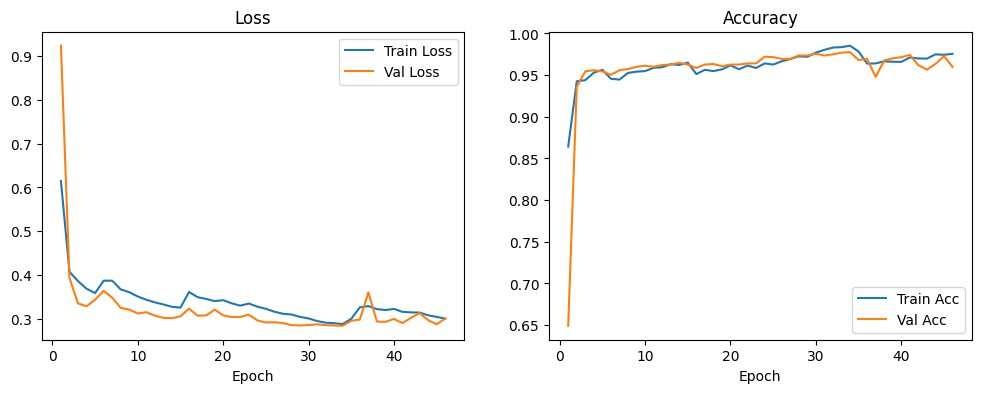

In [6]:
loss = history.history['loss']
val_loss = history.history['val_loss']
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
epochs_range = range(1, len(loss)+1)

plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.plot(epochs_range, loss, label='Train Loss')
plt.plot(epochs_range, val_loss, label='Val Loss')
plt.title('Loss')
plt.xlabel('Epoch')
plt.legend()

plt.subplot(1,2,2)
plt.plot(epochs_range, acc, label='Train Acc')
plt.plot(epochs_range, val_acc, label='Val Acc')
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.show()


## 테스트셋 평가

93/93 ━━━━━━━━━━━━━━━━━━━━ 6s 56ms/step
Test Accuracy: 0.9420
Classification Report:               precision    recall  f1-score   support

           0       1.00      0.99      0.99       496
           1       0.99      0.97      0.98       471
           2       0.97      0.99      0.98       420
           3       0.85      0.84      0.84       491
           4       0.86      0.87      0.87       532
           5       0.99      1.00      1.00       537

    accuracy                           0.94      2947
   macro avg       0.94      0.94      0.94      2947
weighted avg       0.94      0.94      0.94      2947



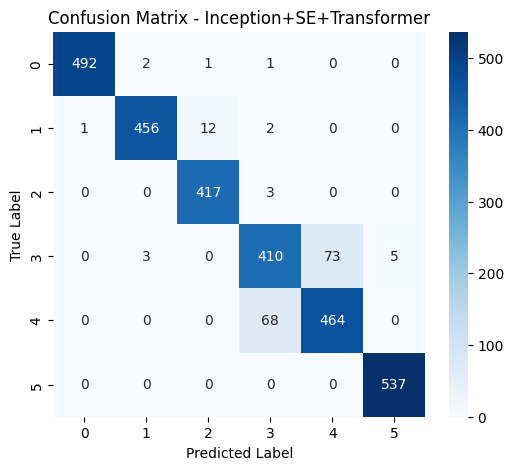

In [10]:
# Best checkpoint 로드 (이미 restore_best_weights=True 이지만 안전하게 재로딩 예시)
if os.path.exists('best_sota_har.h5'):
    model.load_weights('best_sota_har.h5')

pred_prob = model.predict(testX)
pred = np.argmax(pred_prob, axis=-1)
cm = confusion_matrix(testy, pred)
acc = accuracy_score(testy, pred)
print(f'Test Accuracy: {acc:.4f}')
print('Classification Report:', classification_report(testy, pred))

plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix - Inception+SE+Transformer')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()


### 비고
- 본 모델은 InceptionTime(다중 커널 1D CNN)으로 지역 패턴을 강하게 추출하고, SE로 채널 중요도를 재가중하며, Transformer Encoder로 장기 의존성을 보완합니다.
- 기본 전처리는 per-channel 표준화만 적용했습니다. 필요 시 시계열 증강(jitter, scaling 등)을 추가해 일반화를 더 높일 수 있습니다.